https://www.kaggle.com/datasets/sudhanshu2198/processed-data-credit-score/code

In [3]:
import pandas as pd
import numpy as np
com = pd.read_csv('景点.csv')
com = com.drop(['标题链接','图片','bookbtn1','评分','rate','add','图片1','标记','时间'],axis=1)
com=pd.concat([com[com['类型']=='历史人文'],com[com['类型']=='自然生态']],axis=0)
com.rename(columns={'描述':'txt'},inplace=True)
com = com.dropna().reset_index().drop('index',axis=1)

mapping = {'历史人文':0,'自然生态':1}
com['类型'] = com['类型'].map(mapping)

import jieba
stop_word = pd.read_csv('停用词.csv',names=['w'],sep='\t',encoding='utf-8')

df=pd.concat([com[com['类型']==0].sample(n=10000),com[com['类型']==1].sample(n=10000)],axis=0)
df = df.reindex(np.random.permutation(df.index))
df = df.reset_index().drop('index',axis=1)

#这样可以成功
df['cut'] = df.txt.apply(jieba.lcut)
for i in range(len(df.txt)):
    df.cut[i] = [w for w in jieba.cut(df.txt[i]) if w not in list(stop_word.w)]
df.head()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\YANGZH~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.028 seconds.
Prefix dict has been built successfully.
C:\Users\YANGZH~1\AppData\Local\Temp/ipykernel_23284/2839552769.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.cut[i] = [w for w in jieba.cut(df.txt[i]) if w not in list(stop_word.w)]


,标题,类型,txt,cut
0,西安秦岭野生动物园,1,领孩子去玩的，孩子看到了许多动物非常高兴，以后会经常领孩子来玩的，还有马戏表演和海狮的表演孩...,"[领, 动物, 非常高兴, 领, 马戏表演, 海狮, 表演, 喜欢, 逛, 动物园, 满意]"
1,秦始皇帝陵博物院（兵马俑）,0,千里纵横，气吞山河。而最动人之处却是每y形象、表情下的秦时故事，近看非常生动，不得不赞服始皇...,"[千里, 纵横, 气吞山河, 动人, 处, 却是, y, 形象, 表情, 秦时, 故事, 近..."
2,秦始皇帝陵博物院（兵马俑）,0,早点去，没那么多人，携程上订好票，拿身份证就进去，方便的很，市区到那里要近1小时车程，计划好...,"[早点, 多人, 携程, 订好, 票, 身份证, 市区, 要近, 1, 小时, 车程, 计划..."
3,黄帝陵,0,华人必去的地方，但周边环境较差，配套服务设施也没跟上。黄陵县加油！,"[华人, 必去, 周边环境, 较差, 配套, 服务设施, 跟上, 黄陵县, 加油]"
4,安康瀛湖生态旅游区,1,第二次来了，这次的湖水涨了，据说涨了50米。确实是看到和以前不一样了。 门票和船票加起来一共...,"[第二次, 湖水, 涨, 涨, 50, 米, 确实, , 船票, 加, 一共, 80, 1..."


In [5]:
from gensim.models.word2vec import Word2Vec

n_dim = 300 # 指定向量维度，大样本量时300~500较好

w2vmodel = Word2Vec(vector_size = n_dim, min_count = 10) # size改为vector_size
w2vmodel.build_vocab(df.cut) # 生成词表
w2vmodel

In [7]:
# 在评论训练集上建模（大数据集时可能会花费几分钟）
# 本例消耗内存较少 100次 40s
w2vmodel.train(df.txt,total_examples = w2vmodel.corpus_count, epochs = 100)
w2vmodel.wv

In [ ]:
w2vmodel.wv.save_word2vec_format('word2vec.bin')

In [11]:
#查看生成的特征矩阵
import numpy as np

# 假设文本数据为text_data，其中每个元素代表一个文本样本
feature_matrix = np.zeros((len(df.cut), n_dim))

for i,text in enumerate(df.cut):
    #print(i)
    for j,word in enumerate(text):
        if(j<300):
            try:
                feature_matrix[i]+= w2vmodel.wv[word]
            except:
                pass

In [27]:
X = feature_matrix
y = df['类型']

In [28]:
df2=pd.concat([pd.DataFrame(X),y],axis=1)
df2

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,类型
0,-0.444902,1.443579,-5.012238,-3.705452,-0.051508,-2.060765,0.183342,2.727056,0.542888,-2.161844,...,-0.008649,-3.148773,2.016396,2.274120,0.100440,3.657988,-7.172443,-1.453168,0.851038,1
1,-1.312074,-2.520205,-1.875270,-0.104776,1.286043,0.903555,-0.769248,-1.407261,-1.127001,-1.009300,...,0.261822,1.618133,-0.261719,0.447576,0.187161,-0.198379,0.391757,0.019246,-0.920236,0
2,-5.055930,-1.490472,-5.313193,2.226089,-0.042387,0.860641,0.843539,-0.069845,-1.687149,0.560519,...,0.140994,2.067355,1.443887,-0.809261,0.593249,0.052857,-3.079727,-1.438631,0.879639,0
3,-0.005421,0.003225,0.008065,0.002038,0.000045,0.003867,0.002511,0.001687,0.000709,0.006773,...,-0.002766,0.003305,-0.001438,-0.000651,0.005022,0.005923,-0.004811,-0.003774,-0.008551,0
4,-5.898982,-6.278417,-12.074805,-1.256002,-1.618913,-5.862595,-2.618814,-3.760682,-3.231957,0.918449,...,5.093760,6.097307,-2.602517,2.566232,1.398698,-2.747606,-1.706993,-1.373010,3.289517,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-5.602198,-4.579727,-7.356030,3.695037,1.182230,0.738100,-2.852778,-0.118087,-2.821763,-0.893304,...,2.260461,4.699440,0.012579,0.826305,-0.925024,2.075049,-4.329169,-2.394764,0.332104,1
19996,-0.001107,0.001026,0.002040,-0.003459,-0.002136,0.005173,-0.003274,0.003468,0.007142,0.002793,...,-0.007113,-0.004385,-0.008595,0.002861,0.001280,-0.000606,-0.004498,-0.003430,0.001951,0
19997,0.000223,0.002163,0.001957,-0.000059,0.000793,-0.002171,-0.003120,-0.001649,-0.001796,0.000196,...,0.000397,0.002974,0.002138,-0.000480,-0.002070,-0.000352,0.002425,0.002494,-0.001344,0
19998,0.007261,-0.000233,0.004854,0.001596,-0.006400,-0.005533,-0.000221,0.002154,-0.000289,0.003252,...,-0.004272,0.001932,-0.014856,0.002005,0.004452,0.006575,-0.000943,-0.002223,0.007716,1


In [5]:
df2.groupby(by='类型').count()

,0,1,2,3,4,5,6,7,8,9
类型,,,,,,,,,,
0,42625,42625,42625,42625,42625,42625,42625,42625,42625,42625
1,13977,13977,13977,13977,13977,13977,13977,13977,13977,13977


In [15]:
from sklearn.model_selection import train_test_split
import time
from sklearn.svm import SVC

X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.3,random_state=0)

#训练初步模型
model = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
            decision_function_shape='ovr',degree=3, gamma='auto', kernel='rbf',
            max_iter=-1, probability=False, random_state=None, shrinking=True,tol=0.001, verbose=False)

T1 = time.time()
model.fit(X_train,Y_train)
T2 = time.time()

print('训练时间:%s毫秒' % ((T2 - T1)*1000))

predictions = model.predict(X_test)


print(pd.DataFrame([predictions,Y_test]))

训练时间:60751.35827064514毫秒
   0     1     2     3     4     5     6     7     8     9     ...  5990  \
0     1     0     1     0     1     1     0     0     0     0  ...     0   
1     1     1     1     0     1     1     0     0     0     1  ...     0   

   5991  5992  5993  5994  5995  5996  5997  5998  5999  
0     1     0     0     1     0     0     0     0     0  
1     1     1     1     0     1     0     1     1     0  

[2 rows x 6000 columns]


In [16]:
#评价
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,predictions)        # 0.9298245614035088

0.6183333333333333

In [17]:
from sklearn.metrics import accuracy_score,precision_score, \
recall_score,f1_score,cohen_kappa_score
 
print('准确率为：', 
accuracy_score(Y_test,predictions))      
print('精确率为：',
      precision_score(Y_test,predictions,average='weighted'))
print('召回率为：',
      recall_score(Y_test,predictions,average='weighted'))
print('F1值为：',
      f1_score(Y_test,predictions,average='micro'))
print('Cohen’s Kappa系数为：',
      cohen_kappa_score(Y_test,predictions))

准确率为： 0.6183333333333333
精确率为： 0.6227314654967512
召回率为： 0.6183333333333333
F1值为： 0.6183333333333333
Cohen’s Kappa系数为： 0.2339729751909827


In [14]:
predictions.sum()

2936

In [17]:
4 in predictions

True

In [25]:
#交叉验证
def svm_cross_validation(X_train,Y_train):    
    from sklearn.model_selection import GridSearchCV    
    from sklearn.svm import SVC    
    model = SVC(kernel='rbf', probability=True)    
    param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}    
    grid_search = GridSearchCV(model, param_grid, n_jobs = 8, verbose=1)    
    grid_search.fit(X_train,Y_train)    
    best_parameters = grid_search.best_estimator_.get_params()    
    for para, val in list(best_parameters.items()):    
        print(para, val)    
    model = SVC(kernel='rbf', C=best_parameters['C'], gamma=best_parameters['gamma'], probability=True)    
    model.fit(X_train,Y_train)    
    return model

model=svm_cross_validation(X_train,Y_train)

predictions = model.predict(X_test)
print(predictions)
print(accuracy_score(Y_test,predictions))

Fitting 5 folds for each of 14 candidates, totalling 70 fits


KeyboardInterrupt: 

In [22]:
# 决策树
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
import time

X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.3,random_state=0)


clf = DecisionTreeClassifier(random_state=3) # 初始化

T1 = time.time()
clf = clf.fit(X_train,Y_train) # 拟合
T2 = time.time()
print('训练时间:',T2-T1)
score_ = clf.score(X_test, Y_test) # 验证集查看得分，这个得分好像就是分类的准确率

# 可以输入数据送到训练好的模型里，输出预测的类
y_pred = clf.predict(X_test)

#评价
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,y_pred)        # 0.9298245614035088

训练时间: 8.79863452911377


0.6041666666666666

In [19]:
print('精确率为：',
      precision_score(Y_test,y_pred,average='weighted'))
print('召回率为：',
      recall_score(Y_test,y_pred,average='weighted'))
print('F1值为：',
      f1_score(Y_test,y_pred,average='micro'))
print('Cohen’s Kappa系数为：',
      cohen_kappa_score(Y_test,y_pred))

精确率为： 0.604117698561601
召回率为： 0.6041666666666666
F1值为： 0.6041666666666666
Cohen’s Kappa系数为： 0.20802974473548186


Training accuracy: 0.7891428571428571
Test accuracy: 0.6156666666666667
Precision: 0.6156
Recall: 0.6157
F1: 0.6155
[[1942 1104]
 [1202 1752]]


C:\Users\YANGZH~1\AppData\Local\Temp/ipykernel_23284/1914220389.py:36: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('destree_mat_wv.pdf',dpi=300,bbox='tight')


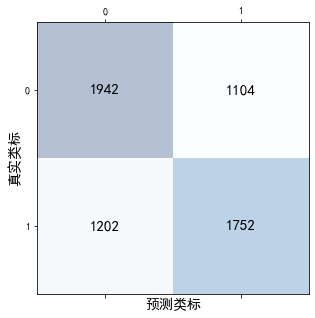

In [21]:
# 以熵作为不纯度度量标准
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.3,random_state=0)
tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 10, random_state = 0)
tree.fit(X_train, Y_train)
# 打印训练集精确度
print('Training accuracy:', tree.score(X_train, Y_train))
# 打印测试集精确度
print('Test accuracy:', tree.score(X_test, Y_test))
# 获取模型的准确率和召回率
from sklearn.metrics import precision_score, recall_score, f1_score
y_pred = tree.predict(X_test)
# 准确率
print('Precision: %.4f' % precision_score(y_true=Y_test, y_pred=y_pred,average='weighted'))
# 召回率
print('Recall: %.4f' % recall_score(y_true=Y_test, y_pred=y_pred,average='weighted'))
# F1
print('F1: %.4f' % f1_score(y_true=Y_test, y_pred=y_pred,average='weighted'))

# 绘制混淆矩阵
from sklearn.metrics import confusion_matrix
y_pred = tree.predict(X_test)
confmat = confusion_matrix(y_true=Y_test, y_pred=y_pred)
print(confmat)
# 将混淆矩阵可视化
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center',fontsize=15)

plt.xlabel('预测类标',fontsize=14)
plt.ylabel('真实类标',fontsize=14)
plt.savefig('destree_mat_wv.pdf',dpi=300,bbox='tight')
plt.show()


In [26]:
y_train.shape

(14000,)

In [34]:
# 贝叶斯
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score # 交叉验证


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 模型实例化
bnb = BernoulliNB()
mnb = MultinomialNB()
gnb = GaussianNB()
# 使用默认参数

# 训练模型
T1 = time.time()
bnb.fit(X_train,y_train)
T2 = time.time()
print(T2-T1,'s')

T1 = time.time()
gnb.fit(X_train,y_train)
T2 = time.time()
print(T2-T1)

# 评估模型
# 分别看一下三个模型,在训练集和测试集的分数
print('bnb模型训练集分数:',bnb.score(X_train,y_train))
print('bnb模型测试集分数:',bnb.score(X_test,y_test))

print('-'*40)
print('gnb模型训练集分数:',gnb.score(X_train,y_train))
print('gnb模型测试集分数:',gnb.score(X_test,y_test))


0.17794251441955566 s
0.07998394966125488
bnb模型训练集分数: 0.6229285714285714
bnb模型测试集分数: 0.623
----------------------------------------
gnb模型训练集分数: 0.5053571428571428
gnb模型测试集分数: 0.4891666666666667


https://blog.csdn.net/peiwang245/article/details/82193702

In [54]:
# 逻辑回归
from sklearn.linear_model import LogisticRegression as LR         
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV  # 网格搜索

# 把整体数据集进行切分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 40)
#在l2范式下，判断C和solver的最优值
p = {
    'C':list(np.linspace(0.05,1,19)),
    'solver':['liblinear','sag','newton-cg','lbfgs']}

model = LR(penalty='l2',max_iter=1000)
GS = GridSearchCV(model,p,cv=5)
GS.fit(X_train,y_train)
#输出最优参数
GS.best_params_


{'C': 0.7361111111111112, 'solver': 'newton-cg'}

In [30]:
# 逻辑回归
from sklearn.linear_model import LogisticRegression        
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import time

# 把整体数据集进行切分
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state = 40)

# 用最优参数训练
log_model = LogisticRegression(penalty='l2',C=0.736,multi_class="multinomial", solver="newton-cg", max_iter=1000)
T1=time.time()
log_model.fit(X_train,Y_train)
T2=time.time()
print(T2-T1)


33.00629925727844


In [31]:
#逻辑回归评价
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import accuracy_score,precision_score, \
recall_score,f1_score,cohen_kappa_score
pred_test = log_model.predict(X_test)
acu = accuracy_score(Y_test, pred_test)  # 准确率
recall = recall_score(Y_test, pred_test, average="macro")  # 召回率
print(acu,recall)

print('精确率为：',
      precision_score(Y_test,pred_test,average='weighted'))
print('召回率为：',
      recall_score(Y_test,pred_test,average='weighted'))
print('F1值为：',
      f1_score(Y_test,pred_test,average='micro'))
print('Cohen’s Kappa系数为：',
      cohen_kappa_score(Y_test,pred_test))

0.6563333333333333 0.6579959854280639
精确率为： 0.6811578860054509
召回率为： 0.6563333333333333
F1值为： 0.6563333333333333
Cohen’s Kappa系数为： 0.31492588884655937


In [36]:
def log(x_train, y_train, x_test, y_test, multi_class, solver):  # multi_class: {ovr','multinomial'}, solver: {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}
    log_model = LogisticRegression(multi_class=multi_class, solver=solver, max_iter=1000)
    log_model.fit(x_train,y_train)
    pred_test = log_model.predict(x_test)
    acu = accuracy_score(y_test, pred_test)
    recall = recall_score(y_test, pred_test, average="macro")
    return acu, recall

def run_log_reg(times, test_size):
    result = {"times":[],
              "multi_class":[],
              "solver":[],
              "acu":[],
              "recall":[]}
    for i in range(times):
        x_train, x_test, y_train, y_test =train_test_split(X, y, test_size=test_size)
        for multi_class in ['ovr','multinomial']:
            for solver in ['newton-cg', 'liblinear', 'lbfgs', 'sag', 'saga']:
                if (multi_class == 'multinomial' and solver == 'liblinear'):
                    continue
                acu, recall = log(x_train, y_train, x_test, y_test, multi_class, solver)
                result["times"].append(i)
                result["multi_class"].append(multi_class)
                result["solver"].append(solver)
                result["acu"].append(acu)
                result["recall"].append(recall)
    df_re =  pd.DataFrame(result)
    ave_acu = df_re.groupby(["multi_class", "solver"])["acu"].mean()
    ave_recall = df_re.groupby(["multi_class", "solver"])["recall"].mean()
    return ave_acu, ave_recall
run_log_reg(5,0.3)

C:\Software\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Software\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Software\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Software\Anaconda\lib\site-packages\sklearn\linear_model\_log

C:\Software\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Software\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Software\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Software\Anaconda\lib\site-packages\sklearn\linear_model\_sag

(multi_class  solver   
 multinomial  lbfgs        0.655433
              newton-cg    0.674467
              sag          0.643000
              saga         0.642233
 ovr          lbfgs        0.649033
              liblinear    0.659033
              newton-cg    0.659133
              sag          0.642267
              saga         0.641000
 Name: acu, dtype: float64,
 multi_class  solver   
 multinomial  lbfgs        0.655579
              newton-cg    0.674596
              sag          0.643135
              saga         0.642363
 ovr          lbfgs        0.649162
              liblinear    0.659157
              newton-cg    0.659257
              sag          0.642397
              saga         0.641150
 Name: recall, dtype: float64)

https://blog.csdn.net/qq_51205385/article/details/127785470

In [32]:
#KNN
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# 创建分类器
clf = KNeighborsClassifier(n_neighbors=3)

# 把整体数据集进行切分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 40)

# 训练数据
T1 = time.time()
clf.fit(X_train,y_train)
T2 = time.time()
print(T2-T1)

# 测试数据
test_predictions = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, test_predictions))
print('MSE:', mean_squared_error(y_test, test_predictions))


0.0070149898529052734
Accuracy: 0.6726666666666666
MSE: 0.3273333333333333


In [33]:
print('准确率为：', 
      accuracy_score(Y_test,pred_test)) 
print('精确率为：',
      precision_score(Y_test,pred_test,average='weighted'))
print('召回率为：',
      recall_score(Y_test,pred_test,average='weighted'))
print('F1值为：',
      f1_score(Y_test,pred_test,average='micro'))
print('Cohen’s Kappa系数为：',
      cohen_kappa_score(Y_test,pred_test))

准确率为： 0.6563333333333333
精确率为： 0.6811578860054509
召回率为： 0.6563333333333333
F1值为： 0.6563333333333333
Cohen’s Kappa系数为： 0.31492588884655937
